# Part 3a - Image Caption Preprocessing (VGG16 Base Model)

## Mount Google Drive unto Colab Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
# Check if in Colab Env
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [4]:
# Change Mount Location
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive/'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/Capstone/Code"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

Colab: mounting Google drive on  /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Colab: making sure  /content/drive//My Drive/Colab Notebooks/Capstone/Code  exists.

Colab: Changing directory to  /content/drive//My Drive/Colab Notebooks/Capstone/Code
/content/drive/My Drive/Colab Notebooks/Capstone/Code


In [5]:
# GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10922798968460429683
 xla_global_id: -1]

## Import Modules

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pickle
import cloudpickle
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter 

# to explore text in captions data
import nltk
nltk.download('stopwords')
import regex as re
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

# to process the images
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# to process the text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for modelling
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

#utilities
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Set Directories

In [7]:
# set directories
BASE_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Data/flickr8k"
WORKING_DIR = mount + "/My Drive/Colab Notebooks/Capstone/Code"

## Load Features From Pickle

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

## Map Image to Captions

In [ ]:
# create mapping of image to captions
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extension from image ID
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = ' '.join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

## Preprocess the Captions Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption = captions[i]
            #preprocessing steps
            #convert to lowercase
            caption = caption.lower()
            #replace all digits, special characters, etc.
            caption = caption.replace('[^A-Za-z]', '')
            #delete additional spaces
            caption = caption.replace('\s+', ' ')
            #add start and end tags to captions
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocessing of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
#preprocess the text
clean(mapping)

In [ ]:
#after preprocessing of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 #index up to the greatest token ID

In [ ]:
#number of unique words
vocab_size

8485

In [ ]:
# get maximum length of caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
type(all_captions)

list

## Train/Test Split

In [ ]:
import random

image_ids = list(mapping.keys())
print(len(image_ids))

8091


In [ ]:
train = random.sample(image_ids, 6091)
test = random.sample(image_ids, 1000)
val = random.sample(image_ids, 1000)

In [ ]:
print(len(train))
print(len(val))
print(len(test))

6091
1000
1000


## Create Data Generation Function

In [ ]:
# create data generator to get data in batches (avoid session crashing)

# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence for common length
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    # encode output sequence (like one hot encoding)
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
                    
                    #store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation - CNN LSTM (BASE MODEL)

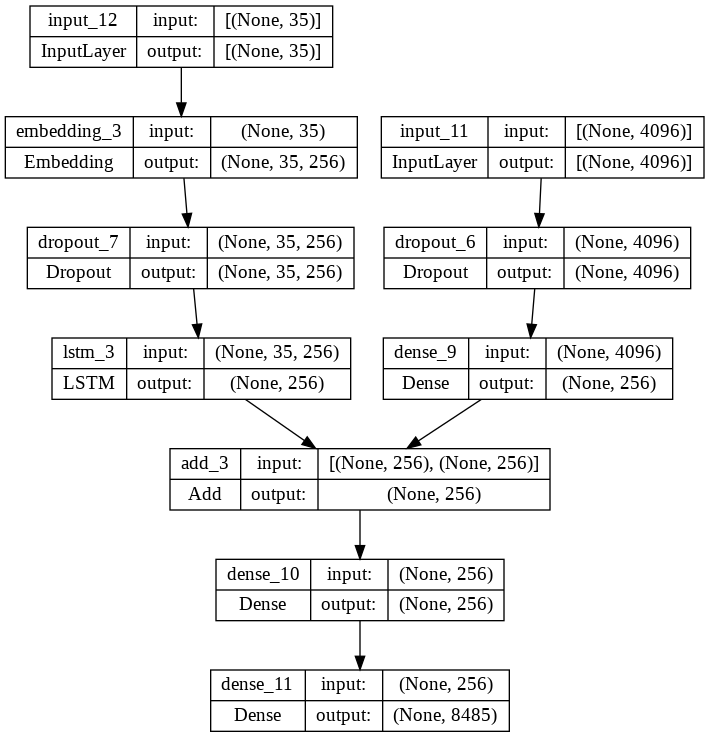

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.3)(inputs1) #set as 0.3 to avoid overfitting
fe2 = Dense(256, activation = 'relu')(fe1)

#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.3)(se1) #set as 0.3 to avoid overfitting
se3 = LSTM(256)(se2)

#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

final_model = Model(inputs=[inputs1, inputs2], outputs = outputs)

# plot the model
plot_model(final_model, show_shapes = True)

In [ ]:
final_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 4096)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 35, 256)      2172160     ['input_12[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 4096)         0           ['input_11[0][0]']               
                                                                                            

## Train the model

In [ ]:
#Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [ ]:
# Train the model
epochs = 300
batch_size = 32
steps = len(train) // batch_size
val_steps = len(test) // batch_size

#Interrupts training when improvement stops and monitor the model's val acc
#Interrupts training when accuracy nas stopped improving for more than 5 epochs.
callbacks_list = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 5,)

#save results of model fit in a CSV file
csv_log = CSVLogger("base_vgg_results.csv")

# create data generator
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#fit for one epoch
history = final_model.fit(generator, epochs = epochs, steps_per_epoch = steps, validation_data=val_generator, callbacks=(callbacks_list, csv_log), validation_steps=val_steps, verbose  = 1)

Epoch 1/300
190/190 [==============================] - 34s 157ms/step - loss: 5.3233 - accuracy: 0.1421 - val_loss: 4.3846 - val_accuracy: 0.2149
Epoch 2/300
190/190 [==============================] - 28s 149ms/step - loss: 4.0962 - accuracy: 0.2438 - val_loss: 3.7203 - val_accuracy: 0.2805
Epoch 3/300
190/190 [==============================] - 29s 150ms/step - loss: 3.6252 - accuracy: 0.2827 - val_loss: 3.4657 - val_accuracy: 0.3017
Epoch 4/300
190/190 [==============================] - 28s 149ms/step - loss: 3.3411 - accuracy: 0.3023 - val_loss: 3.3254 - val_accuracy: 0.3143
Epoch 5/300
190/190 [==============================] - 28s 150ms/step - loss: 3.1315 - accuracy: 0.3191 - val_loss: 3.2164 - val_accuracy: 0.3268
Epoch 6/300
190/190 [==============================] - 29s 151ms/step - loss: 2.9796 - accuracy: 0.3349 - val_loss: 3.1293 - val_accuracy: 0.3375
Epoch 7/300
190/190 [==============================] - 29s 151ms/step - loss: 2.8651 - accuracy: 0.3486 - val_loss: 3.0502 -

In [ ]:
# save the model
final_model.save(WORKING_DIR + '/base_val_vgg_model.h5')

### Visualizing Model Accuracy and Loss

In [8]:
#load CSV file
data = pd.read_csv(mount + "/My Drive/Colab Notebooks/Capstone/Code/base_vgg_results.csv")
data.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.142109,5.323331,0.214866,4.384630
1,1,0.243774,4.096154,0.280469,3.720286
2,2,0.282737,3.625182,0.301673,3.465666
3,3,0.302337,3.341142,0.314342,3.325409
4,4,0.319066,3.131536,0.326806,3.216355


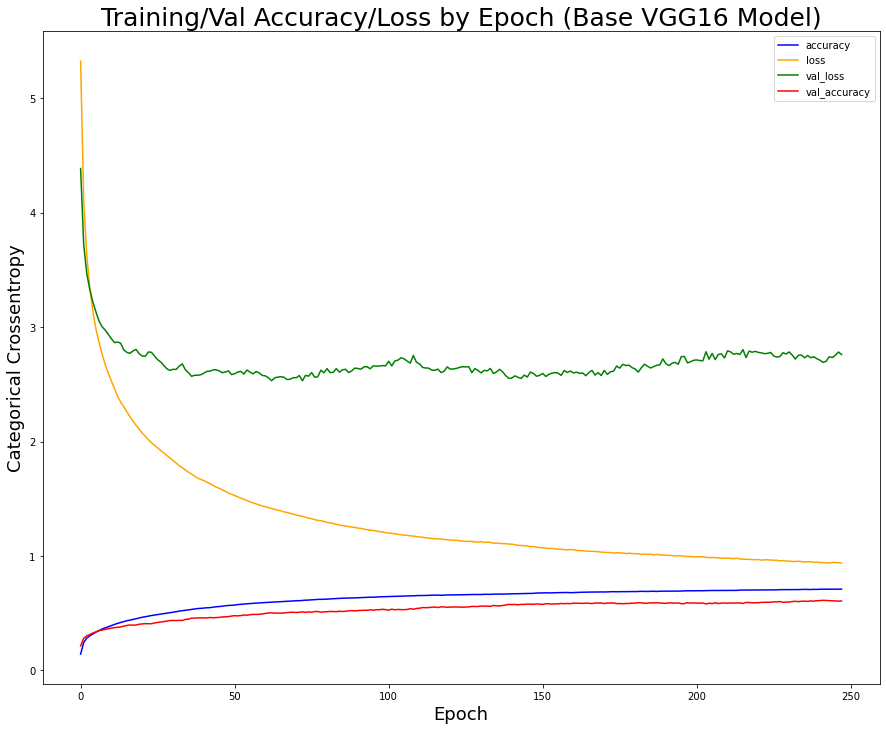

In [18]:
# Plot Training/Val Accuracy/Loss by Epoch for Base VGG16 Model
plt.title('Training/Val Accuracy/Loss by Epoch (Base VGG16 Model)', fontsize = 25)
plt.plot(data['accuracy'], color='blue', label='accuracy')
plt.plot(data['loss'], color='orange', label='loss')
plt.plot(data['val_loss'], color='green', label='val_loss')
plt.plot(data['val_accuracy'], color='red', label='val_accuracy')
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.rcParams["figure.figsize"] = (15,12)
plt.legend()
plt.show()

## Generate Captions for Images

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    #add start tag for generation process
    in_text = 'startseq'
    #iterate over the max length of sequence
    for i in range(max_length):
        #encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence = pad_sequences([sequence], max_length)
        #predict next word
        yhat = final_model.predict([image, sequence], verbose = 0)
        #get index with high probability
        yhat= np.argmax(yhat)
        #convert index to word
        word = idx_to_word(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break
        #append word as input for generation next word
        in_text += ' ' + word
        #stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

### BLEU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    #predict the caption for image
    y_pred = predict_caption(final_model, features[key], tokenizer, max_length)
    #split into words  
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
#calculate BLEU Score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights = (1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights = (0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights = (0.3, 0.3, 0.3, 0.1)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights = (0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.612190
BLEU-2: 0.432365
BLEU-3: 0.369432
BLEU-4: 0.263712


## Visualize the Results of Image Captions

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    #load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-----------Actual-----------')
    for caption in captions:
        print(caption)

    #predict the caption
    y_pred = predict_caption(final_model, features[image_id], tokenizer, max_length)
    print('-----------Predicted-----------')
    print(y_pred)
    plt.imshow(image)

-----------Actual-----------
startseq brown dog walks through snow endseq
startseq brown puppy walking through the snow endseq
startseq dog looks curious at adventures lying ahead in the snow endseq
startseq dog walking in the snow endseq
startseq yellow puppy walking through the snow endseq
-----------Predicted-----------
startseq brown dog is walking in the snow near the snow endseq


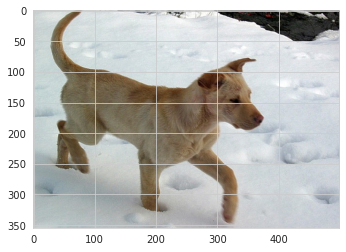

In [ ]:
generate_caption("421808539_57abee6d55.jpg")

-----------Actual-----------
startseq girl rides unicycle as another rides scooter next to her endseq
startseq girl rides unicycle with child who rides scooter endseq
startseq young girl rides unicycle next to another riding scooter on busy street endseq
startseq the girl on the unicycle reaches out for the child on the scooter endseq
startseq there is girl on unicycle and child on scooter endseq
-----------Predicted-----------
startseq two girls who are riding bikes in the street wearing black dress endseq


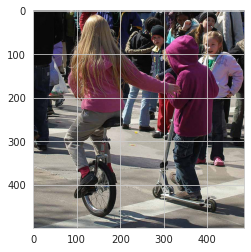

In [ ]:
generate_caption("1193116658_c0161c35b5.jpg")

-----------Actual-----------
startseq boy in white plays baseball endseq
startseq young boy is getting ready to through baseball endseq
startseq little leaguer getting ready for pitch endseq
startseq the boy is wearing white baseball uniform and holding baseball endseq
startseq the young ohio baseball player contemplates his pitch endseq
-----------Predicted-----------
startseq young boy with glove on his head with skull and crossbones sign endseq


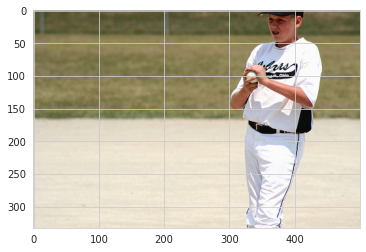

In [ ]:
generate_caption("1285067106_2adc307240.jpg")

-----------Actual-----------
startseq fisherman stands on the beach on gray day endseq
startseq man holding fishing pole and tackle box walking in from the ocean endseq
startseq man in yellow cap is on the beach carrying fishing pole endseq
startseq man with fishing pole standing on beach endseq
startseq person is standing in the ocean fully clothed holding fishing pole in one hand and tackle box in the other endseq
-----------Predicted-----------
startseq man is fishing in the ocean fully clothed with swimmers with the sun attached to his right endseq


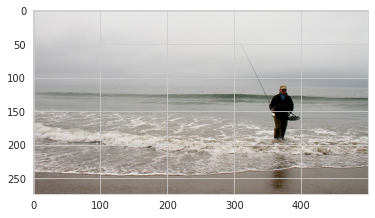

In [ ]:
generate_caption("516725192_c9cdd63878.jpg")